## Tutorial code on Online Feedback Optimization

We are dealing with the following, one-dimensional system (an under-damped oscillator):

$$
\ddot{\zeta}+a\dot{\zeta}+b(\zeta-u)=0,
$$
with $a = 6$, $b=200$, and $y = \zeta$. At steady state, we have $y = \zeta = u$, i.e. $h(u) = u$.

This is a second-order system and can be rewritten in standard state-space form:

$$
\begin{pmatrix}\dot{\zeta} \\ \ddot{\zeta}\end{pmatrix} =
\begin{pmatrix}\dot{x_1}\\\dot{x_2}\end{pmatrix} =
\begin{bmatrix}0 & 1 \\ -b & -a\end{bmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} +
\begin{bmatrix}0 \\ b\end{bmatrix}
u
$$

The initial conditions are $\ddot{\zeta}_0 = \dot{\zeta}_0 = 0, \zeta_0 = 2.5$, and $u_0 = 3$.

We are aiming to minimize the following cost on our steady state:
$$
\Phi(y) = (y^2 - 1) ^ 2
$$

Our discrete Feedback Optimization controller can actuate the system once a second (1Hz).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# matplotlib settings -- DO NOT CHANGE
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#001659', '#c74c00'])

In [3]:
# define system
a = 6
b = 200

A = np.array([[0, 1], [-b, -a]])
B = np.array([[0], [b]])
C = np.array([[1, 0]])

# define time vector
t = np.linspace(0, 20, 2000)

# define phi
def phi(y):
    return (y**2 - 1)**2

# define initial condition
x0 = np.array([2.5, 0])
u0 = 2.5

In [4]:
def plot_objective(ax, Y_constr=[np.nan, np.nan]):
    y = np.linspace(-2, 2, 300)
    phi_y = phi(y)
    ax.plot(y, phi_y)
    ax.plot([-1, 1], [0, 0], ls='', marker='o', color='#c74c00', markeredgecolor='k')
    # plot constraints
    if not np.isnan(Y_constr[0]) or not np.isnan(Y_constr[1]):
        ax.plot([Y_constr[0], Y_constr[0]], [-10, 10], linestyle=':', color='k', zorder=0)
        ax.plot([Y_constr[1], Y_constr[1]], [-10, 10], linestyle=':', color='k', zorder=0)
        ax.fill_between(y, -10, 10, where=(y < Y_constr[0]), color='tab:red', alpha=0.2)
        ax.fill_between(y, -10, 10, where=(y > Y_constr[1]), color='tab:red', alpha=0.2)
        # indicate optimum given constraints (with star)
        ax.plot(Y_constr[0], phi(Y_constr[0]), marker='*', markersize=10, color='#c74c00', markeredgecolor='k')
    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$\Phi(y)$')
    ax.set_title('Objective function')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 10)
    ax.grid(True)

def plot_state_and_input(ax, t, zeta, u, alpha, ylim=[-2.5, 3.5], Y_constr=[np.nan, np.nan]):
    # plot
    ax.plot(t, zeta, label=r'$\zeta$')
    ax.plot(t[1:], u[1:], label=r'$u$', linestyle='--', marker='o', markevery=100, markersize=4)
    ax.set_xlabel(r'$t$')
    ax.set_title(r'$\alpha = {}$'.format(alpha))
    ax.set_ylim(ylim)
    ax.set_xlim(0, 14)
    ax.grid(True)
    ax.legend(loc='lower center')

    # plot constraints
    ax.plot(t, np.ones(len(t)) * Y_constr[0], linestyle=':', color='k', zorder=0)
    ax.plot(t, np.ones(len(t)) * Y_constr[1], linestyle=':', color='k', zorder=0)
    # shade region above u_max and below u_min
    ax.fill_between(t, 0, Y_constr[0], color='tab:red', alpha=0.2)


### Unconstrained Feedback Optimization

Remember:
$$
	u_{k+1} = u_k - \alpha \Big(
		\nabla_u \Phi(u,y) +
		\nabla_u h(u; w)^\top \nabla_y \Phi(u,y)
		   \Big)
$$

The choice of the right step size is crucial. Convergence to the closest local minimum of $\Phi(y)$ is only guaranteed for step sizes small enough. By increasing the step size, can you:
- make the system instable?
- converge to a different local minimum?

In [5]:
# step size
alphas = [
    0.02,
    0.06,
    0.2
]

# define u_dot
def u_dot_unc(y):
    return 4 * y * (y**2 - 1)

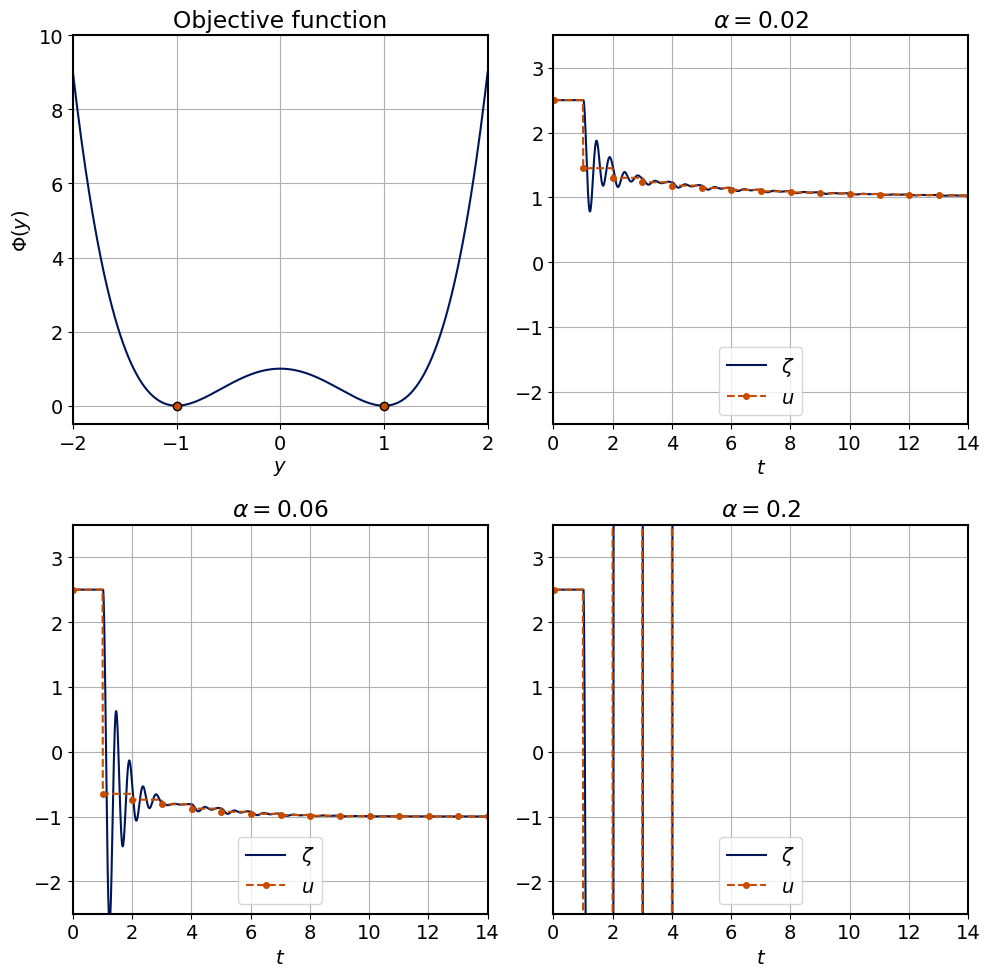

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# in upper left panel, plot phi function
plot_objective(axs[0])

# forward simulate the FO controller, connected to the system
for ax, alpha_i in zip(axs[1:], alphas):
    x = np.zeros((2, len(t)))
    u = np.zeros(len(t))
    x[:, 0] = x0
    u[0] = u0

    for i in range(0, len(t)-1):
        dt = t[i+1] - t[i]

        # catch instability
        if np.abs(x[0, i]) > 1e10:
            # fill nans
            x[:, i+1:] = np.nan
            u[i+1:] = np.nan
            break

        if i % 100 == 0 and i > 0:
            # update control input
            u_dot = u_dot_unc((C @ x[:, i])[0])
            u[i+1] = u[i] - alpha_i * u_dot
        else:
            u[i+1] = u[i]

        # update state (forward Euler)
        x_dot = A @ x[:, i].reshape(2, 1) + B * u[i]
        x[:, i+1] = (x[:, i].reshape(2, 1) + dt * x_dot).flatten()

    plot_state_and_input(ax, t, x[0, :], u, alpha_i)

plt.tight_layout()
plt.show()

### Adding constraints


We now impose the following constraint on the output:

$$
\mathcal{Y} = [1.2, 4]
$$

As seen in the lecture, multiple approaches can be used to iteratively converge to an (approximate) solution of the constrained optimization problem.

We will start with the penalization of constraint violations and then turn to projected gradient descent. Pay attention to the difference in runtime!

#### Penalty function:
$$
	u_{k+1} = u_k - \alpha \Big(
		\nabla_u \Phi(u,y) +
		\nabla_u h(u; w)^\top \nabla_y \Phi(u,y) +
		\nabla_u h(u; w)^\top \nabla_y p(y)
		   \Big)
$$

Implement the penalty term for a quadratic penalty function!

In [7]:
Y_constr = [1.2, 4]

def p_dot(y, beta=10):
    if y < Y_constr[0]:
        return -beta * (Y_constr[0] - y)
    elif y > Y_constr[1]:
        return beta * (y - Y_constr[1])
    else:
        return 0

def u_dot_penalty(y):
    return 4 * y * (y**2 - 1) + p_dot(y)

In [8]:
alpha = 0.02 # keep at this value now

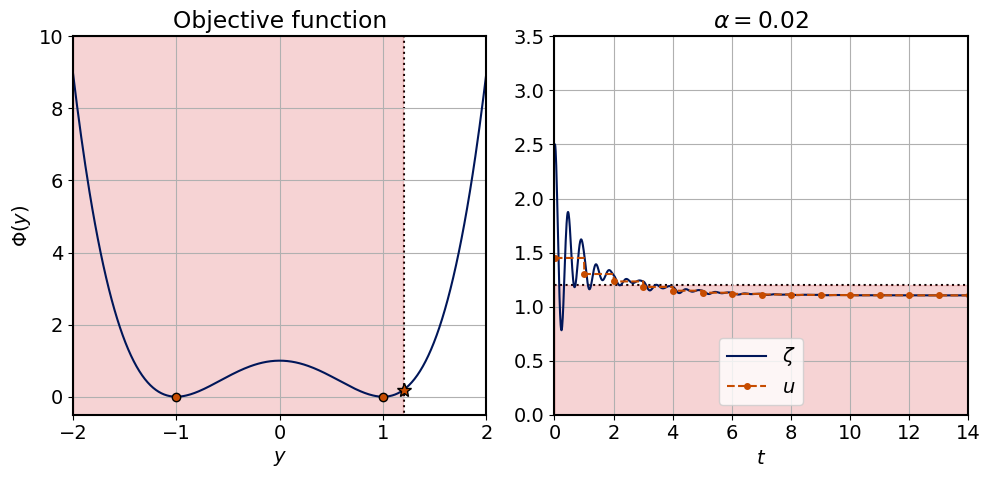

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

# in left panel, plot phi function
plot_objective(axs[0], Y_constr=Y_constr)

# forward simulate the FO controller, connected to the system
x = np.zeros((2, len(t)))
u = np.zeros(len(t))
x[:, 0] = x0
u[0] = u0

for i in range(0, len(t)-1):
    dt = t[i+1] - t[i]

    # catch instability
    if np.abs(x[0, i]) > 1e10:
        # fill nans
        x[:, i+1:] = np.nan
        u[i+1:] = np.nan
        break

    if i % 100 == 0:
        # update control input
        u_dot = u_dot_penalty((C @ x[:, i])[0])
        u[i+1] = u[i] - alpha * u_dot
    else:
        u[i+1] = u[i]

    x_dot = A @ x[:, i].reshape(2, 1) + B * u[i]
    x[:, i+1] = (x[:, i].reshape(2, 1) + dt * x_dot).flatten()

# plot
plot_state_and_input(axs[1], t, x[0, :], u, alpha, ylim=[0, 3.5], Y_constr=Y_constr)

plt.tight_layout()
plt.show()

#### Projected gradient descent:

Remember from the lecture:
$$
			u_{k+1} = u_k + \alpha \delta u
$$

where $\delta u$ is the solution of a simple quadratic program

\begin{align*}
			    \delta u := \text{argmin}_{v} & \quad \Big\| v - \underbrace{\left( -\nabla_u \Phi(u,y) - \nabla h(u;w)^\top \nabla_y \Phi(u,y) \right)}_\text{gradient}  \Big\|^2 \\
  \text{s.t.}  & \quad A (u+ \alpha v)\leq b \\
 & \quad C (y+ \alpha \nabla h(u;w)^\top v)\leq d
\end{align*}

In [10]:
def u_dot_proj(alpha, y):
    # find the projection of y onto the constraint by solving QP
    from scipy.optimize import minimize
    grad = u_dot_unc(y)
    constraints = [
        {'type': 'ineq', 'fun': lambda v: (y - alpha * v) - Y_constr[0]},
        {'type': 'ineq', 'fun': lambda v: -(y - alpha * v) + Y_constr[1]}
    ]
    res = minimize(lambda v: (v - grad)**2, x0=2, constraints=constraints, tol=1e-3)
    if not res.success:
        print(res.message)
    return res.x[0]

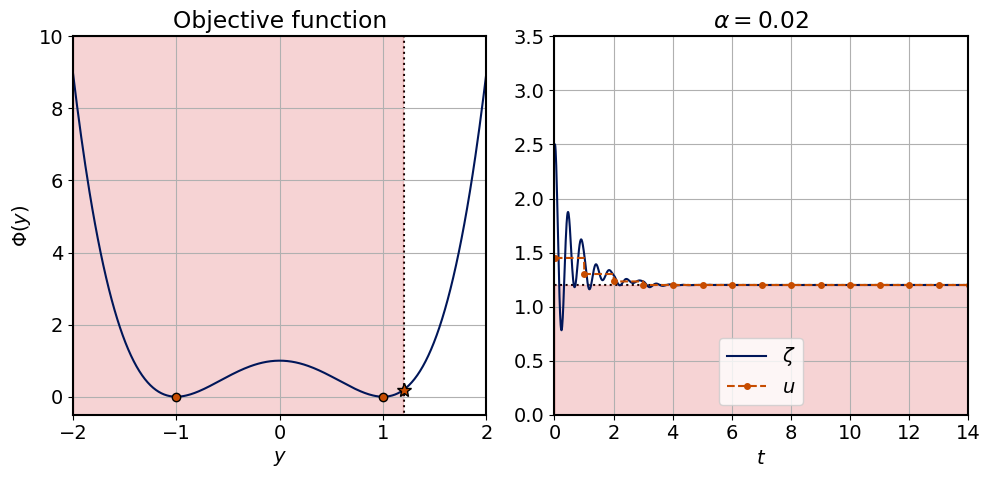

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

# in left panel, plot phi function
plot_objective(axs[0], Y_constr=Y_constr)

# forward simulate the FO controller, connected to the system
x = np.zeros((2, len(t)))
u = np.zeros(len(t))
x[:, 0] = x0
u[0] = u0

for i in range(0, len(t)-1):
    dt = t[i+1] - t[i]

    # catch instability
    if np.abs(x[0, i]) > 1e10:
        # fill nans
        x[:, i+1:] = np.nan
        u[i+1:] = np.nan
        break

    if i % 100 == 0:
        # update control input
        u_dot = u_dot_proj(alpha, (C @ x[:, i])[0])
        u[i+1] = u[i] - alpha * u_dot
    else:
        u[i+1] = u[i]

    x_dot = A @ x[:, i].reshape(2, 1) + B * u[i]
    x[:, i+1] = (x[:, i].reshape(2, 1) + dt * x_dot).flatten()

# plot
plot_state_and_input(axs[1], t, x[0, :], u, alpha, ylim=[0, 3.5], Y_constr=Y_constr)

plt.tight_layout()
plt.show()

### Bonus: Robustness

In the lecture, you have seen that Feedback Optimization is robust to certain disturbances or model uncertainties due to its feedback nature. Let's put that to the test!

Our system is now perturbed by a constant disturbance $w \equiv \bar{w} = 2$:
$$
\begin{pmatrix}\dot{\zeta} \\ \ddot{\zeta}\end{pmatrix} =
\begin{pmatrix}\dot{x_1}\\\dot{x_2}\end{pmatrix} =
\begin{bmatrix}0 & 1 \\ -b & -a\end{bmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} +
\begin{bmatrix}0 \\ b\end{bmatrix}
u +
\begin{bmatrix}\bar{w} \\ 0\end{bmatrix}
$$

As a consequence, the new steady-state map becomes
$$
h(u, w) = u + L\bar{w},
$$
for some L.

However, our controller is not aware of this disturbance (i.e. assumes $\bar{w} = 0$) and still works with the old steady-state map and corresponding sensitivities. Does the controller still converge to the optimal steady-state?

What do you observe regarding the steady-state input and output?

In [12]:
w_bar = 5

In [13]:
alpha = 0.02

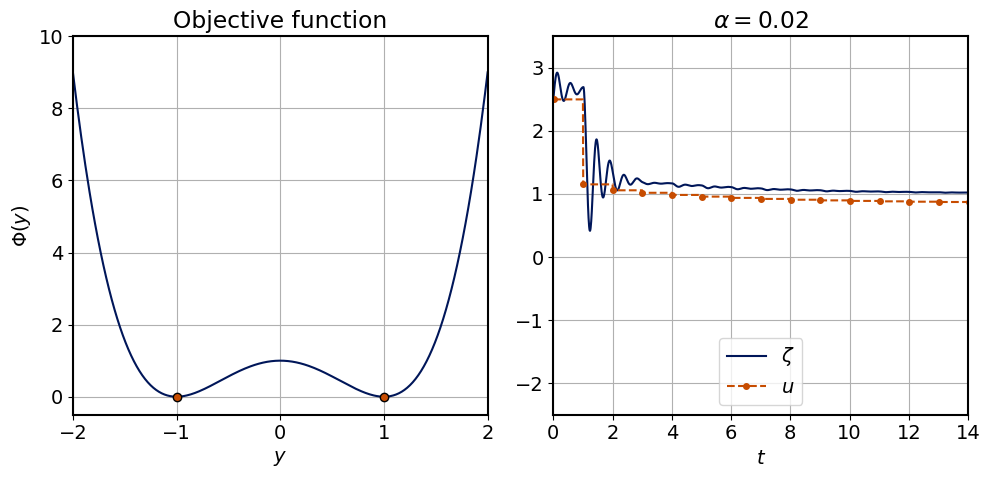

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

# in upper left panel, plot phi function
plot_objective(axs[0])

# forward simulate the FO controller, connected to the system
x = np.zeros((2, len(t)))
u = np.zeros(len(t))
x[:, 0] = x0
u[0] = u0

for i in range(0, len(t)-1):
    dt = t[i+1] - t[i]

    # catch instability
    if np.abs(x[0, i]) > 1e10:
        # fill nans
        x[:, i+1:] = np.nan
        u[i+1:] = np.nan
        break

    if i % 100 == 0 and i > 0:
        # update control input
        u_dot = u_dot_unc((C @ x[:, i])[0])
        u[i+1] = u[i] - alpha * u_dot
    else:
        u[i+1] = u[i]

    # update state (forward Euler)
    x_dot = A @ x[:, i].reshape(2, 1) + B * u[i] + np.array([[w_bar],[0]])
    x[:, i+1] = (x[:, i].reshape(2, 1) + dt * x_dot).flatten()

plot_state_and_input(axs[1], t, x[0, :], u, alpha)
plt.tight_layout()
plt.show()